In [55]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.utils
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import average_precision_score, accuracy_score, recall_score, precision_score, f1_score
import torchvision.models as models
from efficientnet_pytorch import EfficientNet
import pandas as pd
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

In [56]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [57]:
# Set the paths
root_folder = r"C:\ThesisMedia\CroppedPralines\Grouped_dataset\Thesis_Dataset_Lighting"
output_dir = r"C:\ThesisMedia\CroppedPralines\Grouped_dataset\Thesis_Dataset_Lighting\Outputs"

# Set the device (CUDA if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the Luminance to study
Luminance = [60, 80, 110, 130, 150, 170, 190]

In [58]:
batch_size = 64
num_epochs = 7
num_classes = 2
window_size = 2 # Smoothing plot curve
num_workers = 8

In [59]:
# Define the models to test
models_to_test = [
    ('vgg11_bn', models.vgg11_bn(pretrained=True)),
    ('ResNet_bn', models.resnet50(pretrained=True)),
    ('Inception_bn', models.inception_v3(pretrained=True)),
    ('EfficientNet_bn', EfficientNet.from_pretrained('efficientnet-b0')),
    ('MobileNet_bn', models.mobilenet_v2(pretrained=True))
]

In [60]:
def get_transform(model_name):
    if model_name == 'Inception_bn':
        transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    else:
        transform = transforms.Compose([
        # transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform

In [61]:
def create_data_loader(dataset, batch_size, shuffle):
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=False
    )

In [62]:
def modify_classification_layer(model, model_name, num_classes):
    # Modify the classification layer for the model
        if model_name == 'EfficientNet_bn':
            model._fc = nn.Sequential(
                nn.Linear(in_features=1280, out_features=512),
                nn.BatchNorm1d(512),
                nn.ReLU(),
                nn.Dropout(0.5),  # Add dropout layer with dropout rate of 0.5
                nn.Linear(in_features=512, out_features=num_classes)
            )
        elif model_name == 'MobileNet_bn':
            num_features = model.classifier[-1].in_features
            model.classifier[-1] = nn.Linear(in_features=num_features, out_features=num_classes)
            
        elif model_name == 'ResNet_bn' or model_name == 'Inception_bn':
            num_features = model.fc.in_features
            model.fc = nn.Linear(in_features=num_features, out_features=num_classes)
        else:
            num_features = model.classifier[-1].in_features
            model.classifier[-1] = nn.Linear(in_features=num_features, out_features=num_classes)  # 2 classes: Good and Bad


In [63]:
def train_model(model, train_loader, val_loader, model_name, train_luma, num_epochs):

    global train_results_df

    # Modify the classification layer for the model
    modify_classification_layer(model, model_name, num_classes)
    
    model.to(device)

    # Define your loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    train_map_values = []
    val_map_values = []
    train_accuracy_values = []
    val_accuracy_values = []
    y_true_train = []
    y_pred_train = []
    y_true_val = []
    y_pred_val = []

    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        train_correct = 0
        train_total = 0
        y_true_train = []
        y_pred_train = []

        # Create a progress bar for the training loop
        progress_bar = tqdm(train_loader, desc=f"Model: {model_name} - Training Luma: {train_luma} - Epoch {epoch + 1}/{num_epochs}", leave=False)

        for images, labels in progress_bar:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            if model_name == 'Inception_bn':
                outputs, _ = model(images)
            else:
                outputs = model(images)

            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            # Update the progress bar with the current loss
            progress_bar.set_postfix({"Loss": loss.item()})

            # Store the true labels and predicted labels for mAP calculation
            y_true_train.extend(labels.cpu().numpy())
            y_pred_train.extend(predicted.cpu().numpy())

        epoch_loss = running_loss / len(train_loader)
        epoch_train_accuracy = train_correct / train_total
        train_map = average_precision_score(y_true_train, y_pred_train)
        train_map_values.append(train_map)
        train_accuracy_values.append(epoch_train_accuracy)
        print(f"Model - {model_name} : Training - {train_luma} - Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {epoch_loss:.4f} - Training Accuracy: {epoch_train_accuracy:.4f}")

        if epoch == 0 or train_map > max(train_map_values[:-1]):
            torch.save(model.state_dict(), f'{output_dir}/Model_{model_name}_{train_luma}.pt')

        # Clear GPU cache to free up memory
        torch.cuda.empty_cache()

        # Validation loop
        model.eval()  # Set model to evaluation mode
        val_correct = 0
        val_total = 0
        y_true_val = []
        y_pred_val = []

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs.data, 1)

                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                # Store the true labels and predicted labels for mAP calculation
                y_true_val.extend(labels.cpu().numpy())
                y_pred_val.extend(predicted.cpu().numpy())

        epoch_val_accuracy = val_correct / val_total
        val_map = average_precision_score(y_true_val, y_pred_val)
        val_map_values.append(val_map)
        val_accuracy = accuracy_score(y_true_val, y_pred_val)
        val_accuracy_values.append(val_accuracy)
        print(f"Validation - {train_luma} - Epoch [{epoch + 1}/{num_epochs}] - Validation Accuracy: {epoch_val_accuracy:.4f}")

        # Clear GPU cache to free up memory
        torch.cuda.empty_cache()

    end_time = time.time()
    global training_duration
    training_duration = end_time - start_time

    # Smooth the mAP curve using a moving average with a window size of 5
    smoothed_train_map_values = np.convolve(train_map_values, np.ones(window_size) / window_size, mode='valid')
    smoothed_val_map_values = np.convolve(val_map_values, np.ones(window_size) / window_size, mode='valid')

    # Plot the training and validation mAP graph
    plt.plot(range(window_size, num_epochs + 1), smoothed_train_map_values, label=f'Training')
    plt.plot(range(window_size, num_epochs + 1), smoothed_val_map_values, label=f'Validation')
    plt.xlabel('Epoch')
    plt.ylabel('mAP')
    plt.title(f'mAP for {model_name} - Luminance : {train_luma}')
    plt.legend(loc='upper left')
    plt.savefig(f'{output_dir}/mAP_Plot_Light_training/{model_name}_Luma_{train_luma}_mAP_graph.png')
    plt.close()
    
    train_result = pd.DataFrame({
            'Model': model_name,
            'Train_Luminance': train_luma,
            'Training_Duration':training_duration,
            'Train_mAP':train_map_values[-1],
            'val_mAP': val_map_values[-1],
            'Train_Accuracy': train_accuracy_values[-1],
            'val_Accuracy': val_accuracy_values[-1]
    }, index=[0])
    
    train_results_df = pd.concat([train_results_df, train_result], ignore_index=True)

    # Clear GPU cache to free up memory
    torch.cuda.empty_cache()

In [64]:
def test_model(model, test_loader, model_name, train_luma, test_luma):
    global test_results_df
    model.eval()  # Set model to evaluation mode
    test_y_true = []
    test_y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)

            # Store the true labels and predicted labels for mAP calculation
            test_y_true.extend(labels.cpu().numpy())
            test_y_pred.extend(predicted.cpu().numpy())

    # Calculate metrics for the test set
    test_accuracy = accuracy_score(test_y_true, test_y_pred)
    test_recall = recall_score(test_y_true, test_y_pred)
    test_precision = precision_score(test_y_true, test_y_pred)
    test_f1_score = f1_score(test_y_true, test_y_pred)
    test_map = average_precision_score(test_y_true, test_y_pred)

    test_result = pd.DataFrame({
            'Model': model_name,
            'Train_Luminance': train_luma,
            'Test_Luminance': test_luma,
            'Test_mAP': test_map,
            'Test_Accuracy': test_accuracy,
            'Test_Recall': test_recall,
            'Test_Precision':test_precision,
            'Test_F1_Score': test_f1_score
    }, index=[0])

    test_results_df = pd.concat([test_results_df, test_result], ignore_index=True)


In [65]:
def main():
    global train_results_df
    global test_results_df
    train_results_df = pd.DataFrame(columns=['Model', 'Train_Luminance','Training_Duration', 'Train_mAP',
                                             'Train_Accuracy', 'val_Accuracy', 'val_mAP'])
    test_results_df = pd.DataFrame(columns=['Model', 'Train_Luminance', 'Test_Luminance', 
                          'Test_mAP', 'Test_Accuracy', 'Test_Recall', 'Test_Precision', 'Test_F1_Score'])
    # Separate DataFrames to store training mAP values for each model
    training_mAP_data = {}

    for model_name, model in models_to_test:
        model = model.to(device)

        for train_luma in Luminance:
            # Load train dataset
            train_dataset = ImageFolder(root=os.path.join(root_folder, f'Train_{train_luma}'), transform=get_transform(model_name))

             # Split the dataset into training and validation sets (80-20 split)
            train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(42))

            train_loader = create_data_loader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = create_data_loader(val_dataset, batch_size=batch_size, shuffle=False)

            # Train the model and plot the training and validation mAP for the training Luminance
            train_model(model, train_loader, val_loader, model_name, train_luma, num_epochs)

            # Load test datasets for all Luminance
            for test_luma in Luminance:
                test_dataset = ImageFolder(root=os.path.join(root_folder, f'Test_{test_luma}'), transform=get_transform(model_name))
                test_loader = create_data_loader(test_dataset, batch_size=batch_size, shuffle=False)
                print(f"Testing - {model_name}; Train Luma: {train_luma}, Test Luma: {test_luma} - size: {len(test_dataset)}")

                # Test the model on the test dataset
                model.load_state_dict(torch.load(f'{output_dir}/Model_{model_name}_{train_luma}.pt'))
                model.to(device)
                test_model(model, test_loader, model_name, train_luma, test_luma)

        # Clear GPU cache to free up memory
        torch.cuda.empty_cache()

    train_results_df.to_excel(f'{output_dir}/Training_results.xlsx', index=False)
    test_results_df.to_excel(f'{output_dir}/Testing_results.xlsx', index=False)


In [66]:
if __name__ == '__main__':
    torch.multiprocessing.freeze_support()
    main()

Model - vgg11_bn : Training - 60 - Epoch [1/7] - Training Loss: 1.2528 - Training Accuracy: 0.7750
Validation - 60 - Epoch [1/7] - Validation Accuracy: 0.9200


Model - vgg11_bn : Training - 60 - Epoch [2/7] - Training Loss: 0.1748 - Training Accuracy: 0.9587
Validation - 60 - Epoch [2/7] - Validation Accuracy: 0.8900


Model - vgg11_bn : Training - 60 - Epoch [3/7] - Training Loss: 0.0835 - Training Accuracy: 0.9750
Validation - 60 - Epoch [3/7] - Validation Accuracy: 0.9200


Model - vgg11_bn : Training - 60 - Epoch [4/7] - Training Loss: 0.0386 - Training Accuracy: 0.9850
Validation - 60 - Epoch [4/7] - Validation Accuracy: 0.9600


Model - vgg11_bn : Training - 60 - Epoch [5/7] - Training Loss: 0.0351 - Training Accuracy: 0.9875
Validation - 60 - Epoch [5/7] - Validation Accuracy: 0.9600


Model - vgg11_bn : Training - 60 - Epoch [6/7] - Training Loss: 0.0706 - Training Accuracy: 0.9962
Validation - 60 - Epoch [6/7] - Validation Accuracy: 0.9750


Model - vgg11_bn : Training - 60 - Epoch [7/7] - Training Loss: 0.1856 - Training Accuracy: 0.9525
Validation - 60 - Epoch [7/7] - Validation Accuracy: 0.9350
Testing - vgg11_bn; Train Luma: 60, Test Luma: 60 - size: 600
Testing - vgg11_bn; Train Luma: 60, Test Luma: 80 - size: 600
Testing - vgg11_bn; Train Luma: 60, Test Luma: 110 - size: 600
Testing - vgg11_bn; Train Luma: 60, Test Luma: 130 - size: 600
Testing - vgg11_bn; Train Luma: 60, Test Luma: 150 - size: 600
Testing - vgg11_bn; Train Luma: 60, Test Luma: 170 - size: 600
Testing - vgg11_bn; Train Luma: 60, Test Luma: 190 - size: 600


Model - vgg11_bn : Training - 80 - Epoch [1/7] - Training Loss: 0.7772 - Training Accuracy: 0.7963
Validation - 80 - Epoch [1/7] - Validation Accuracy: 0.8400


Model - vgg11_bn : Training - 80 - Epoch [2/7] - Training Loss: 0.2813 - Training Accuracy: 0.9637
Validation - 80 - Epoch [2/7] - Validation Accuracy: 0.9350


Model - vgg11_bn : Training - 80 - Epoch [3/7] - Training Loss: 0.0364 - Training Accuracy: 0.9875
Validation - 80 - Epoch [3/7] - Validation Accuracy: 0.9250


Model - vgg11_bn : Training - 80 - Epoch [4/7] - Training Loss: 0.2849 - Training Accuracy: 0.9725
Validation - 80 - Epoch [4/7] - Validation Accuracy: 0.9700


Model - vgg11_bn : Training - 80 - Epoch [5/7] - Training Loss: 0.1917 - Training Accuracy: 0.9800
Validation - 80 - Epoch [5/7] - Validation Accuracy: 0.9500


Model - vgg11_bn : Training - 80 - Epoch [6/7] - Training Loss: 0.0248 - Training Accuracy: 0.9938
Validation - 80 - Epoch [6/7] - Validation Accuracy: 0.9700


Model - vgg11_bn : Training - 80 - Epoch [7/7] - Training Loss: 0.4682 - Training Accuracy: 0.9788
Validation - 80 - Epoch [7/7] - Validation Accuracy: 0.9600
Testing - vgg11_bn; Train Luma: 80, Test Luma: 60 - size: 600
Testing - vgg11_bn; Train Luma: 80, Test Luma: 80 - size: 600
Testing - vgg11_bn; Train Luma: 80, Test Luma: 110 - size: 600
Testing - vgg11_bn; Train Luma: 80, Test Luma: 130 - size: 600
Testing - vgg11_bn; Train Luma: 80, Test Luma: 150 - size: 600
Testing - vgg11_bn; Train Luma: 80, Test Luma: 170 - size: 600
Testing - vgg11_bn; Train Luma: 80, Test Luma: 190 - size: 600


Model - vgg11_bn : Training - 110 - Epoch [1/7] - Training Loss: 0.2500 - Training Accuracy: 0.9200
Validation - 110 - Epoch [1/7] - Validation Accuracy: 0.9650


Model - vgg11_bn : Training - 110 - Epoch [2/7] - Training Loss: 0.0874 - Training Accuracy: 0.9775
Validation - 110 - Epoch [2/7] - Validation Accuracy: 0.9500


Model - vgg11_bn : Training - 110 - Epoch [3/7] - Training Loss: 0.0985 - Training Accuracy: 0.9625
Validation - 110 - Epoch [3/7] - Validation Accuracy: 0.9800


Model - vgg11_bn : Training - 110 - Epoch [4/7] - Training Loss: 0.0394 - Training Accuracy: 0.9900
Validation - 110 - Epoch [4/7] - Validation Accuracy: 0.9750


Model - vgg11_bn : Training - 110 - Epoch [5/7] - Training Loss: 0.0711 - Training Accuracy: 0.9925
Validation - 110 - Epoch [5/7] - Validation Accuracy: 0.9350


Model - vgg11_bn : Training - 110 - Epoch [6/7] - Training Loss: 0.1482 - Training Accuracy: 0.9663
Validation - 110 - Epoch [6/7] - Validation Accuracy: 0.9650


Model - vgg11_bn : Training - 110 - Epoch [7/7] - Training Loss: 0.0161 - Training Accuracy: 0.9962
Validation - 110 - Epoch [7/7] - Validation Accuracy: 0.9850
Testing - vgg11_bn; Train Luma: 110, Test Luma: 60 - size: 600
Testing - vgg11_bn; Train Luma: 110, Test Luma: 80 - size: 600
Testing - vgg11_bn; Train Luma: 110, Test Luma: 110 - size: 600
Testing - vgg11_bn; Train Luma: 110, Test Luma: 130 - size: 600
Testing - vgg11_bn; Train Luma: 110, Test Luma: 150 - size: 600
Testing - vgg11_bn; Train Luma: 110, Test Luma: 170 - size: 600
Testing - vgg11_bn; Train Luma: 110, Test Luma: 190 - size: 600


Model - vgg11_bn : Training - 130 - Epoch [1/7] - Training Loss: 0.5437 - Training Accuracy: 0.8588
Validation - 130 - Epoch [1/7] - Validation Accuracy: 0.9800


Model - vgg11_bn : Training - 130 - Epoch [2/7] - Training Loss: 0.0692 - Training Accuracy: 0.9838
Validation - 130 - Epoch [2/7] - Validation Accuracy: 0.9750


Model - vgg11_bn : Training - 130 - Epoch [3/7] - Training Loss: 0.0752 - Training Accuracy: 0.9700
Validation - 130 - Epoch [3/7] - Validation Accuracy: 0.9600


Model - vgg11_bn : Training - 130 - Epoch [4/7] - Training Loss: 0.1675 - Training Accuracy: 0.9613
Validation - 130 - Epoch [4/7] - Validation Accuracy: 0.9750


Model - vgg11_bn : Training - 130 - Epoch [5/7] - Training Loss: 0.0830 - Training Accuracy: 0.9775
Validation - 130 - Epoch [5/7] - Validation Accuracy: 0.9250


Model - vgg11_bn : Training - 130 - Epoch [6/7] - Training Loss: 0.0288 - Training Accuracy: 0.9912
Validation - 130 - Epoch [6/7] - Validation Accuracy: 0.9750


Model - vgg11_bn : Training - 130 - Epoch [7/7] - Training Loss: 0.0190 - Training Accuracy: 0.9950
Validation - 130 - Epoch [7/7] - Validation Accuracy: 0.9800
Testing - vgg11_bn; Train Luma: 130, Test Luma: 60 - size: 600
Testing - vgg11_bn; Train Luma: 130, Test Luma: 80 - size: 600
Testing - vgg11_bn; Train Luma: 130, Test Luma: 110 - size: 600
Testing - vgg11_bn; Train Luma: 130, Test Luma: 130 - size: 600
Testing - vgg11_bn; Train Luma: 130, Test Luma: 150 - size: 600
Testing - vgg11_bn; Train Luma: 130, Test Luma: 170 - size: 600
Testing - vgg11_bn; Train Luma: 130, Test Luma: 190 - size: 600


Model - vgg11_bn : Training - 150 - Epoch [1/7] - Training Loss: 0.2359 - Training Accuracy: 0.9350
Validation - 150 - Epoch [1/7] - Validation Accuracy: 0.9750


Model - vgg11_bn : Training - 150 - Epoch [2/7] - Training Loss: 0.0654 - Training Accuracy: 0.9888
Validation - 150 - Epoch [2/7] - Validation Accuracy: 0.9750


Model - vgg11_bn : Training - 150 - Epoch [3/7] - Training Loss: 0.0574 - Training Accuracy: 0.9825
Validation - 150 - Epoch [3/7] - Validation Accuracy: 0.9800


Model - vgg11_bn : Training - 150 - Epoch [4/7] - Training Loss: 0.0524 - Training Accuracy: 0.9862
Validation - 150 - Epoch [4/7] - Validation Accuracy: 0.9750


Model - vgg11_bn : Training - 150 - Epoch [5/7] - Training Loss: 0.0332 - Training Accuracy: 0.9862
Validation - 150 - Epoch [5/7] - Validation Accuracy: 0.9700


Model - vgg11_bn : Training - 150 - Epoch [6/7] - Training Loss: 0.0121 - Training Accuracy: 0.9938
Validation - 150 - Epoch [6/7] - Validation Accuracy: 0.9700


Model - vgg11_bn : Training - 150 - Epoch [7/7] - Training Loss: 0.0578 - Training Accuracy: 0.9938
Validation - 150 - Epoch [7/7] - Validation Accuracy: 0.9350
Testing - vgg11_bn; Train Luma: 150, Test Luma: 60 - size: 600
Testing - vgg11_bn; Train Luma: 150, Test Luma: 80 - size: 600
Testing - vgg11_bn; Train Luma: 150, Test Luma: 110 - size: 600
Testing - vgg11_bn; Train Luma: 150, Test Luma: 130 - size: 600
Testing - vgg11_bn; Train Luma: 150, Test Luma: 150 - size: 600
Testing - vgg11_bn; Train Luma: 150, Test Luma: 170 - size: 600
Testing - vgg11_bn; Train Luma: 150, Test Luma: 190 - size: 600


Model - vgg11_bn : Training - 170 - Epoch [1/7] - Training Loss: 0.3014 - Training Accuracy: 0.9625
Validation - 170 - Epoch [1/7] - Validation Accuracy: 0.9975


Model - vgg11_bn : Training - 170 - Epoch [2/7] - Training Loss: 0.0235 - Training Accuracy: 0.9906
Validation - 170 - Epoch [2/7] - Validation Accuracy: 0.9775


Model - vgg11_bn : Training - 170 - Epoch [3/7] - Training Loss: 0.0182 - Training Accuracy: 0.9950
Validation - 170 - Epoch [3/7] - Validation Accuracy: 0.9925


Model - vgg11_bn : Training - 170 - Epoch [4/7] - Training Loss: 0.2031 - Training Accuracy: 0.9944
Validation - 170 - Epoch [4/7] - Validation Accuracy: 0.9950


Model - vgg11_bn : Training - 170 - Epoch [5/7] - Training Loss: 0.0262 - Training Accuracy: 0.9925
Validation - 170 - Epoch [5/7] - Validation Accuracy: 0.9700


Model - vgg11_bn : Training - 170 - Epoch [6/7] - Training Loss: 0.0678 - Training Accuracy: 0.9862
Validation - 170 - Epoch [6/7] - Validation Accuracy: 0.9850


Model - vgg11_bn : Training - 170 - Epoch [7/7] - Training Loss: 0.0026 - Training Accuracy: 0.9981
Validation - 170 - Epoch [7/7] - Validation Accuracy: 0.9950
Testing - vgg11_bn; Train Luma: 170, Test Luma: 60 - size: 600
Testing - vgg11_bn; Train Luma: 170, Test Luma: 80 - size: 600
Testing - vgg11_bn; Train Luma: 170, Test Luma: 110 - size: 600
Testing - vgg11_bn; Train Luma: 170, Test Luma: 130 - size: 600
Testing - vgg11_bn; Train Luma: 170, Test Luma: 150 - size: 600
Testing - vgg11_bn; Train Luma: 170, Test Luma: 170 - size: 600
Testing - vgg11_bn; Train Luma: 170, Test Luma: 190 - size: 600


Model - vgg11_bn : Training - 190 - Epoch [1/7] - Training Loss: 0.2200 - Training Accuracy: 0.9437
Validation - 190 - Epoch [1/7] - Validation Accuracy: 0.9850


Model - vgg11_bn : Training - 190 - Epoch [2/7] - Training Loss: 0.0241 - Training Accuracy: 0.9962
Validation - 190 - Epoch [2/7] - Validation Accuracy: 0.9600


Model - vgg11_bn : Training - 190 - Epoch [3/7] - Training Loss: 0.0872 - Training Accuracy: 0.9825
Validation - 190 - Epoch [3/7] - Validation Accuracy: 0.8850


Model - vgg11_bn : Training - 190 - Epoch [4/7] - Training Loss: 0.0078 - Training Accuracy: 0.9950
Validation - 190 - Epoch [4/7] - Validation Accuracy: 0.9850


Model - vgg11_bn : Training - 190 - Epoch [5/7] - Training Loss: 0.0392 - Training Accuracy: 0.9888
Validation - 190 - Epoch [5/7] - Validation Accuracy: 0.9700


Model - vgg11_bn : Training - 190 - Epoch [6/7] - Training Loss: 0.0232 - Training Accuracy: 0.9925
Validation - 190 - Epoch [6/7] - Validation Accuracy: 0.9750


Model - vgg11_bn : Training - 190 - Epoch [7/7] - Training Loss: 0.0473 - Training Accuracy: 0.9900
Validation - 190 - Epoch [7/7] - Validation Accuracy: 0.9450
Testing - vgg11_bn; Train Luma: 190, Test Luma: 60 - size: 600
Testing - vgg11_bn; Train Luma: 190, Test Luma: 80 - size: 600
Testing - vgg11_bn; Train Luma: 190, Test Luma: 110 - size: 600
Testing - vgg11_bn; Train Luma: 190, Test Luma: 130 - size: 600
Testing - vgg11_bn; Train Luma: 190, Test Luma: 150 - size: 600
Testing - vgg11_bn; Train Luma: 190, Test Luma: 170 - size: 600
Testing - vgg11_bn; Train Luma: 190, Test Luma: 190 - size: 600


Model - ResNet_bn : Training - 60 - Epoch [1/7] - Training Loss: 0.4136 - Training Accuracy: 0.8287
Validation - 60 - Epoch [1/7] - Validation Accuracy: 0.9100


Model - ResNet_bn : Training - 60 - Epoch [2/7] - Training Loss: 0.1481 - Training Accuracy: 0.9537
Validation - 60 - Epoch [2/7] - Validation Accuracy: 0.9550


Model - ResNet_bn : Training - 60 - Epoch [3/7] - Training Loss: 0.1604 - Training Accuracy: 0.9313
Validation - 60 - Epoch [3/7] - Validation Accuracy: 0.9150


Model - ResNet_bn : Training - 60 - Epoch [4/7] - Training Loss: 0.0246 - Training Accuracy: 0.9912
Validation - 60 - Epoch [4/7] - Validation Accuracy: 0.9200


Model - ResNet_bn : Training - 60 - Epoch [5/7] - Training Loss: 0.1043 - Training Accuracy: 0.9712
Validation - 60 - Epoch [5/7] - Validation Accuracy: 0.8950


Model - ResNet_bn : Training - 60 - Epoch [6/7] - Training Loss: 0.0627 - Training Accuracy: 0.9838
Validation - 60 - Epoch [6/7] - Validation Accuracy: 0.9500


Model - ResNet_bn : Training - 60 - Epoch [7/7] - Training Loss: 0.0177 - Training Accuracy: 0.9938
Validation - 60 - Epoch [7/7] - Validation Accuracy: 0.9350
Testing - ResNet_bn; Train Luma: 60, Test Luma: 60 - size: 600
Testing - ResNet_bn; Train Luma: 60, Test Luma: 80 - size: 600
Testing - ResNet_bn; Train Luma: 60, Test Luma: 110 - size: 600
Testing - ResNet_bn; Train Luma: 60, Test Luma: 130 - size: 600
Testing - ResNet_bn; Train Luma: 60, Test Luma: 150 - size: 600
Testing - ResNet_bn; Train Luma: 60, Test Luma: 170 - size: 600
Testing - ResNet_bn; Train Luma: 60, Test Luma: 190 - size: 600


Model - ResNet_bn : Training - 80 - Epoch [1/7] - Training Loss: 0.2439 - Training Accuracy: 0.8938
Validation - 80 - Epoch [1/7] - Validation Accuracy: 0.8300


Model - ResNet_bn : Training - 80 - Epoch [2/7] - Training Loss: 0.0789 - Training Accuracy: 0.9637
Validation - 80 - Epoch [2/7] - Validation Accuracy: 0.9350


Model - ResNet_bn : Training - 80 - Epoch [3/7] - Training Loss: 0.0641 - Training Accuracy: 0.9800
Validation - 80 - Epoch [3/7] - Validation Accuracy: 0.9400


Model - ResNet_bn : Training - 80 - Epoch [4/7] - Training Loss: 0.0331 - Training Accuracy: 0.9862
Validation - 80 - Epoch [4/7] - Validation Accuracy: 0.9350


Model - ResNet_bn : Training - 80 - Epoch [5/7] - Training Loss: 0.0137 - Training Accuracy: 0.9962
Validation - 80 - Epoch [5/7] - Validation Accuracy: 0.9600


Model - ResNet_bn : Training - 80 - Epoch [6/7] - Training Loss: 0.0129 - Training Accuracy: 0.9950
Validation - 80 - Epoch [6/7] - Validation Accuracy: 0.9450


Model - ResNet_bn : Training - 80 - Epoch [7/7] - Training Loss: 0.0291 - Training Accuracy: 0.9900
Validation - 80 - Epoch [7/7] - Validation Accuracy: 0.8550
Testing - ResNet_bn; Train Luma: 80, Test Luma: 60 - size: 600
Testing - ResNet_bn; Train Luma: 80, Test Luma: 80 - size: 600
Testing - ResNet_bn; Train Luma: 80, Test Luma: 110 - size: 600
Testing - ResNet_bn; Train Luma: 80, Test Luma: 130 - size: 600
Testing - ResNet_bn; Train Luma: 80, Test Luma: 150 - size: 600
Testing - ResNet_bn; Train Luma: 80, Test Luma: 170 - size: 600
Testing - ResNet_bn; Train Luma: 80, Test Luma: 190 - size: 600


Model - ResNet_bn : Training - 110 - Epoch [1/7] - Training Loss: 0.2434 - Training Accuracy: 0.8825
Validation - 110 - Epoch [1/7] - Validation Accuracy: 0.8800


Model - ResNet_bn : Training - 110 - Epoch [2/7] - Training Loss: 0.0535 - Training Accuracy: 0.9812
Validation - 110 - Epoch [2/7] - Validation Accuracy: 0.9700


Model - ResNet_bn : Training - 110 - Epoch [3/7] - Training Loss: 0.0676 - Training Accuracy: 0.9688
Validation - 110 - Epoch [3/7] - Validation Accuracy: 0.9300


Model - ResNet_bn : Training - 110 - Epoch [4/7] - Training Loss: 0.0277 - Training Accuracy: 0.9888
Validation - 110 - Epoch [4/7] - Validation Accuracy: 0.9450


Model - ResNet_bn : Training - 110 - Epoch [5/7] - Training Loss: 0.0088 - Training Accuracy: 0.9975
Validation - 110 - Epoch [5/7] - Validation Accuracy: 0.9850


Model - ResNet_bn : Training - 110 - Epoch [6/7] - Training Loss: 0.0048 - Training Accuracy: 0.9975
Validation - 110 - Epoch [6/7] - Validation Accuracy: 0.9800


Model - ResNet_bn : Training - 110 - Epoch [7/7] - Training Loss: 0.0054 - Training Accuracy: 0.9988
Validation - 110 - Epoch [7/7] - Validation Accuracy: 0.9850
Testing - ResNet_bn; Train Luma: 110, Test Luma: 60 - size: 600
Testing - ResNet_bn; Train Luma: 110, Test Luma: 80 - size: 600
Testing - ResNet_bn; Train Luma: 110, Test Luma: 110 - size: 600
Testing - ResNet_bn; Train Luma: 110, Test Luma: 130 - size: 600
Testing - ResNet_bn; Train Luma: 110, Test Luma: 150 - size: 600
Testing - ResNet_bn; Train Luma: 110, Test Luma: 170 - size: 600
Testing - ResNet_bn; Train Luma: 110, Test Luma: 190 - size: 600


Model - ResNet_bn : Training - 130 - Epoch [1/7] - Training Loss: 0.1574 - Training Accuracy: 0.9062
Validation - 130 - Epoch [1/7] - Validation Accuracy: 0.9350


Model - ResNet_bn : Training - 130 - Epoch [2/7] - Training Loss: 0.0566 - Training Accuracy: 0.9738
Validation - 130 - Epoch [2/7] - Validation Accuracy: 0.9750


Model - ResNet_bn : Training - 130 - Epoch [3/7] - Training Loss: 0.0425 - Training Accuracy: 0.9812
Validation - 130 - Epoch [3/7] - Validation Accuracy: 0.9850


Model - ResNet_bn : Training - 130 - Epoch [4/7] - Training Loss: 0.0225 - Training Accuracy: 0.9875
Validation - 130 - Epoch [4/7] - Validation Accuracy: 0.9450


Model - ResNet_bn : Training - 130 - Epoch [5/7] - Training Loss: 0.0044 - Training Accuracy: 0.9988
Validation - 130 - Epoch [5/7] - Validation Accuracy: 0.9750


Model - ResNet_bn : Training - 130 - Epoch [6/7] - Training Loss: 0.0013 - Training Accuracy: 1.0000
Validation - 130 - Epoch [6/7] - Validation Accuracy: 0.9850


Model - ResNet_bn : Training - 130 - Epoch [7/7] - Training Loss: 0.0004 - Training Accuracy: 1.0000
Validation - 130 - Epoch [7/7] - Validation Accuracy: 0.9850
Testing - ResNet_bn; Train Luma: 130, Test Luma: 60 - size: 600
Testing - ResNet_bn; Train Luma: 130, Test Luma: 80 - size: 600
Testing - ResNet_bn; Train Luma: 130, Test Luma: 110 - size: 600
Testing - ResNet_bn; Train Luma: 130, Test Luma: 130 - size: 600
Testing - ResNet_bn; Train Luma: 130, Test Luma: 150 - size: 600
Testing - ResNet_bn; Train Luma: 130, Test Luma: 170 - size: 600
Testing - ResNet_bn; Train Luma: 130, Test Luma: 190 - size: 600


Model - ResNet_bn : Training - 150 - Epoch [1/7] - Training Loss: 0.1274 - Training Accuracy: 0.9038
Validation - 150 - Epoch [1/7] - Validation Accuracy: 0.9950


Model - ResNet_bn : Training - 150 - Epoch [2/7] - Training Loss: 0.0179 - Training Accuracy: 0.9950
Validation - 150 - Epoch [2/7] - Validation Accuracy: 0.9800


Model - ResNet_bn : Training - 150 - Epoch [3/7] - Training Loss: 0.0285 - Training Accuracy: 0.9888
Validation - 150 - Epoch [3/7] - Validation Accuracy: 0.9450


Model - ResNet_bn : Training - 150 - Epoch [4/7] - Training Loss: 0.0405 - Training Accuracy: 0.9812
Validation - 150 - Epoch [4/7] - Validation Accuracy: 0.9750


Model - ResNet_bn : Training - 150 - Epoch [5/7] - Training Loss: 0.0120 - Training Accuracy: 0.9962
Validation - 150 - Epoch [5/7] - Validation Accuracy: 0.9800


Model - ResNet_bn : Training - 150 - Epoch [6/7] - Training Loss: 0.0082 - Training Accuracy: 0.9975
Validation - 150 - Epoch [6/7] - Validation Accuracy: 0.9700


Model - ResNet_bn : Training - 150 - Epoch [7/7] - Training Loss: 0.0131 - Training Accuracy: 0.9962
Validation - 150 - Epoch [7/7] - Validation Accuracy: 0.9750
Testing - ResNet_bn; Train Luma: 150, Test Luma: 60 - size: 600
Testing - ResNet_bn; Train Luma: 150, Test Luma: 80 - size: 600
Testing - ResNet_bn; Train Luma: 150, Test Luma: 110 - size: 600
Testing - ResNet_bn; Train Luma: 150, Test Luma: 130 - size: 600
Testing - ResNet_bn; Train Luma: 150, Test Luma: 150 - size: 600
Testing - ResNet_bn; Train Luma: 150, Test Luma: 170 - size: 600
Testing - ResNet_bn; Train Luma: 150, Test Luma: 190 - size: 600


Model - ResNet_bn : Training - 170 - Epoch [1/7] - Training Loss: 0.1078 - Training Accuracy: 0.9569
Validation - 170 - Epoch [1/7] - Validation Accuracy: 0.9850


Model - ResNet_bn : Training - 170 - Epoch [2/7] - Training Loss: 0.0260 - Training Accuracy: 0.9919
Validation - 170 - Epoch [2/7] - Validation Accuracy: 0.9875


Model - ResNet_bn : Training - 170 - Epoch [3/7] - Training Loss: 0.0083 - Training Accuracy: 0.9975
Validation - 170 - Epoch [3/7] - Validation Accuracy: 0.9950


Model - ResNet_bn : Training - 170 - Epoch [4/7] - Training Loss: 0.0027 - Training Accuracy: 0.9994
Validation - 170 - Epoch [4/7] - Validation Accuracy: 0.9950


Model - ResNet_bn : Training - 170 - Epoch [5/7] - Training Loss: 0.0012 - Training Accuracy: 1.0000
Validation - 170 - Epoch [5/7] - Validation Accuracy: 0.9925


Model - ResNet_bn : Training - 170 - Epoch [6/7] - Training Loss: 0.0021 - Training Accuracy: 0.9994
Validation - 170 - Epoch [6/7] - Validation Accuracy: 0.9850


Model - ResNet_bn : Training - 170 - Epoch [7/7] - Training Loss: 0.0413 - Training Accuracy: 0.9869
Validation - 170 - Epoch [7/7] - Validation Accuracy: 0.9775
Testing - ResNet_bn; Train Luma: 170, Test Luma: 60 - size: 600
Testing - ResNet_bn; Train Luma: 170, Test Luma: 80 - size: 600
Testing - ResNet_bn; Train Luma: 170, Test Luma: 110 - size: 600
Testing - ResNet_bn; Train Luma: 170, Test Luma: 130 - size: 600
Testing - ResNet_bn; Train Luma: 170, Test Luma: 150 - size: 600
Testing - ResNet_bn; Train Luma: 170, Test Luma: 170 - size: 600
Testing - ResNet_bn; Train Luma: 170, Test Luma: 190 - size: 600


Model - ResNet_bn : Training - 190 - Epoch [1/7] - Training Loss: 0.0669 - Training Accuracy: 0.9762
Validation - 190 - Epoch [1/7] - Validation Accuracy: 0.9650


Model - ResNet_bn : Training - 190 - Epoch [2/7] - Training Loss: 0.0126 - Training Accuracy: 0.9962
Validation - 190 - Epoch [2/7] - Validation Accuracy: 0.9700


Model - ResNet_bn : Training - 190 - Epoch [3/7] - Training Loss: 0.0096 - Training Accuracy: 0.9962
Validation - 190 - Epoch [3/7] - Validation Accuracy: 0.9800


Model - ResNet_bn : Training - 190 - Epoch [4/7] - Training Loss: 0.0270 - Training Accuracy: 0.9900
Validation - 190 - Epoch [4/7] - Validation Accuracy: 0.9800


Model - ResNet_bn : Training - 190 - Epoch [5/7] - Training Loss: 0.0144 - Training Accuracy: 0.9938
Validation - 190 - Epoch [5/7] - Validation Accuracy: 0.9900


Model - ResNet_bn : Training - 190 - Epoch [6/7] - Training Loss: 0.0127 - Training Accuracy: 0.9962
Validation - 190 - Epoch [6/7] - Validation Accuracy: 0.9950


Model - ResNet_bn : Training - 190 - Epoch [7/7] - Training Loss: 0.0012 - Training Accuracy: 1.0000
Validation - 190 - Epoch [7/7] - Validation Accuracy: 0.9900
Testing - ResNet_bn; Train Luma: 190, Test Luma: 60 - size: 600
Testing - ResNet_bn; Train Luma: 190, Test Luma: 80 - size: 600
Testing - ResNet_bn; Train Luma: 190, Test Luma: 110 - size: 600
Testing - ResNet_bn; Train Luma: 190, Test Luma: 130 - size: 600
Testing - ResNet_bn; Train Luma: 190, Test Luma: 150 - size: 600
Testing - ResNet_bn; Train Luma: 190, Test Luma: 170 - size: 600
Testing - ResNet_bn; Train Luma: 190, Test Luma: 190 - size: 600


Model - Inception_bn : Training - 60 - Epoch [1/7] - Training Loss: 0.3097 - Training Accuracy: 0.8575
Validation - 60 - Epoch [1/7] - Validation Accuracy: 0.7900


Model - Inception_bn : Training - 60 - Epoch [2/7] - Training Loss: 0.0752 - Training Accuracy: 0.9738
Validation - 60 - Epoch [2/7] - Validation Accuracy: 0.8550


Model - Inception_bn : Training - 60 - Epoch [3/7] - Training Loss: 0.0450 - Training Accuracy: 0.9838
Validation - 60 - Epoch [3/7] - Validation Accuracy: 0.8800


Model - Inception_bn : Training - 60 - Epoch [4/7] - Training Loss: 0.0145 - Training Accuracy: 0.9962
Validation - 60 - Epoch [4/7] - Validation Accuracy: 0.9750


Model - Inception_bn : Training - 60 - Epoch [5/7] - Training Loss: 0.0272 - Training Accuracy: 0.9875
Validation - 60 - Epoch [5/7] - Validation Accuracy: 0.9550


Model - Inception_bn : Training - 60 - Epoch [6/7] - Training Loss: 0.0606 - Training Accuracy: 0.9800
Validation - 60 - Epoch [6/7] - Validation Accuracy: 0.8950


Model - Inception_bn : Training - 60 - Epoch [7/7] - Training Loss: 0.0190 - Training Accuracy: 0.9962
Validation - 60 - Epoch [7/7] - Validation Accuracy: 0.9650
Testing - Inception_bn; Train Luma: 60, Test Luma: 60 - size: 600
Testing - Inception_bn; Train Luma: 60, Test Luma: 80 - size: 600
Testing - Inception_bn; Train Luma: 60, Test Luma: 110 - size: 600
Testing - Inception_bn; Train Luma: 60, Test Luma: 130 - size: 600
Testing - Inception_bn; Train Luma: 60, Test Luma: 150 - size: 600
Testing - Inception_bn; Train Luma: 60, Test Luma: 170 - size: 600
Testing - Inception_bn; Train Luma: 60, Test Luma: 190 - size: 600


Model - Inception_bn : Training - 80 - Epoch [1/7] - Training Loss: 0.1618 - Training Accuracy: 0.9300
Validation - 80 - Epoch [1/7] - Validation Accuracy: 0.8350


Model - Inception_bn : Training - 80 - Epoch [2/7] - Training Loss: 0.0529 - Training Accuracy: 0.9825
Validation - 80 - Epoch [2/7] - Validation Accuracy: 0.9000


Model - Inception_bn : Training - 80 - Epoch [3/7] - Training Loss: 0.0357 - Training Accuracy: 0.9888
Validation - 80 - Epoch [3/7] - Validation Accuracy: 0.9350


Model - Inception_bn : Training - 80 - Epoch [4/7] - Training Loss: 0.0312 - Training Accuracy: 0.9875
Validation - 80 - Epoch [4/7] - Validation Accuracy: 0.9650


Model - Inception_bn : Training - 80 - Epoch [5/7] - Training Loss: 0.0297 - Training Accuracy: 0.9888
Validation - 80 - Epoch [5/7] - Validation Accuracy: 0.9550


Model - Inception_bn : Training - 80 - Epoch [6/7] - Training Loss: 0.0150 - Training Accuracy: 0.9950
Validation - 80 - Epoch [6/7] - Validation Accuracy: 0.9600


Model - Inception_bn : Training - 80 - Epoch [7/7] - Training Loss: 0.0215 - Training Accuracy: 0.9938
Validation - 80 - Epoch [7/7] - Validation Accuracy: 0.9600
Testing - Inception_bn; Train Luma: 80, Test Luma: 60 - size: 600
Testing - Inception_bn; Train Luma: 80, Test Luma: 80 - size: 600
Testing - Inception_bn; Train Luma: 80, Test Luma: 110 - size: 600
Testing - Inception_bn; Train Luma: 80, Test Luma: 130 - size: 600
Testing - Inception_bn; Train Luma: 80, Test Luma: 150 - size: 600
Testing - Inception_bn; Train Luma: 80, Test Luma: 170 - size: 600
Testing - Inception_bn; Train Luma: 80, Test Luma: 190 - size: 600


Model - Inception_bn : Training - 110 - Epoch [1/7] - Training Loss: 0.1499 - Training Accuracy: 0.9375
Validation - 110 - Epoch [1/7] - Validation Accuracy: 0.8250


Model - Inception_bn : Training - 110 - Epoch [2/7] - Training Loss: 0.0540 - Training Accuracy: 0.9838
Validation - 110 - Epoch [2/7] - Validation Accuracy: 0.9850


Model - Inception_bn : Training - 110 - Epoch [3/7] - Training Loss: 0.0248 - Training Accuracy: 0.9912
Validation - 110 - Epoch [3/7] - Validation Accuracy: 0.9100


Model - Inception_bn : Training - 110 - Epoch [4/7] - Training Loss: 0.0352 - Training Accuracy: 0.9888
Validation - 110 - Epoch [4/7] - Validation Accuracy: 0.9750


Model - Inception_bn : Training - 110 - Epoch [5/7] - Training Loss: 0.0151 - Training Accuracy: 0.9962
Validation - 110 - Epoch [5/7] - Validation Accuracy: 0.9650


Model - Inception_bn : Training - 110 - Epoch [6/7] - Training Loss: 0.0105 - Training Accuracy: 0.9962
Validation - 110 - Epoch [6/7] - Validation Accuracy: 0.9400


Model - Inception_bn : Training - 110 - Epoch [7/7] - Training Loss: 0.0051 - Training Accuracy: 0.9975
Validation - 110 - Epoch [7/7] - Validation Accuracy: 0.9800
Testing - Inception_bn; Train Luma: 110, Test Luma: 60 - size: 600
Testing - Inception_bn; Train Luma: 110, Test Luma: 80 - size: 600
Testing - Inception_bn; Train Luma: 110, Test Luma: 110 - size: 600
Testing - Inception_bn; Train Luma: 110, Test Luma: 130 - size: 600
Testing - Inception_bn; Train Luma: 110, Test Luma: 150 - size: 600
Testing - Inception_bn; Train Luma: 110, Test Luma: 170 - size: 600
Testing - Inception_bn; Train Luma: 110, Test Luma: 190 - size: 600


Model - Inception_bn : Training - 130 - Epoch [1/7] - Training Loss: 0.1265 - Training Accuracy: 0.9463
Validation - 130 - Epoch [1/7] - Validation Accuracy: 0.9600


Model - Inception_bn : Training - 130 - Epoch [2/7] - Training Loss: 0.0502 - Training Accuracy: 0.9762
Validation - 130 - Epoch [2/7] - Validation Accuracy: 0.9050


Model - Inception_bn : Training - 130 - Epoch [3/7] - Training Loss: 0.0355 - Training Accuracy: 0.9862
Validation - 130 - Epoch [3/7] - Validation Accuracy: 0.9400


Model - Inception_bn : Training - 130 - Epoch [4/7] - Training Loss: 0.0315 - Training Accuracy: 0.9925
Validation - 130 - Epoch [4/7] - Validation Accuracy: 0.9850


Model - Inception_bn : Training - 130 - Epoch [5/7] - Training Loss: 0.0296 - Training Accuracy: 0.9875
Validation - 130 - Epoch [5/7] - Validation Accuracy: 0.9750


Model - Inception_bn : Training - 130 - Epoch [6/7] - Training Loss: 0.0070 - Training Accuracy: 0.9988
Validation - 130 - Epoch [6/7] - Validation Accuracy: 0.9800


Model - Inception_bn : Training - 130 - Epoch [7/7] - Training Loss: 0.0062 - Training Accuracy: 0.9988
Validation - 130 - Epoch [7/7] - Validation Accuracy: 0.9850
Testing - Inception_bn; Train Luma: 130, Test Luma: 60 - size: 600
Testing - Inception_bn; Train Luma: 130, Test Luma: 80 - size: 600
Testing - Inception_bn; Train Luma: 130, Test Luma: 110 - size: 600
Testing - Inception_bn; Train Luma: 130, Test Luma: 130 - size: 600
Testing - Inception_bn; Train Luma: 130, Test Luma: 150 - size: 600
Testing - Inception_bn; Train Luma: 130, Test Luma: 170 - size: 600
Testing - Inception_bn; Train Luma: 130, Test Luma: 190 - size: 600


Model - Inception_bn : Training - 150 - Epoch [1/7] - Training Loss: 0.1074 - Training Accuracy: 0.9663
Validation - 150 - Epoch [1/7] - Validation Accuracy: 0.9900


Model - Inception_bn : Training - 150 - Epoch [2/7] - Training Loss: 0.0320 - Training Accuracy: 0.9888
Validation - 150 - Epoch [2/7] - Validation Accuracy: 0.9950


Model - Inception_bn : Training - 150 - Epoch [3/7] - Training Loss: 0.0374 - Training Accuracy: 0.9875
Validation - 150 - Epoch [3/7] - Validation Accuracy: 0.9550


Model - Inception_bn : Training - 150 - Epoch [4/7] - Training Loss: 0.0149 - Training Accuracy: 0.9962
Validation - 150 - Epoch [4/7] - Validation Accuracy: 0.9750


Model - Inception_bn : Training - 150 - Epoch [5/7] - Training Loss: 0.0085 - Training Accuracy: 0.9975
Validation - 150 - Epoch [5/7] - Validation Accuracy: 0.9650


Model - Inception_bn : Training - 150 - Epoch [6/7] - Training Loss: 0.0049 - Training Accuracy: 0.9975
Validation - 150 - Epoch [6/7] - Validation Accuracy: 0.9850


Model - Inception_bn : Training - 150 - Epoch [7/7] - Training Loss: 0.0083 - Training Accuracy: 0.9962
Validation - 150 - Epoch [7/7] - Validation Accuracy: 0.9600
Testing - Inception_bn; Train Luma: 150, Test Luma: 60 - size: 600
Testing - Inception_bn; Train Luma: 150, Test Luma: 80 - size: 600
Testing - Inception_bn; Train Luma: 150, Test Luma: 110 - size: 600
Testing - Inception_bn; Train Luma: 150, Test Luma: 130 - size: 600
Testing - Inception_bn; Train Luma: 150, Test Luma: 150 - size: 600
Testing - Inception_bn; Train Luma: 150, Test Luma: 170 - size: 600
Testing - Inception_bn; Train Luma: 150, Test Luma: 190 - size: 600


Model - Inception_bn : Training - 170 - Epoch [1/7] - Training Loss: 0.0863 - Training Accuracy: 0.9631
Validation - 170 - Epoch [1/7] - Validation Accuracy: 0.9850


Model - Inception_bn : Training - 170 - Epoch [2/7] - Training Loss: 0.0188 - Training Accuracy: 0.9938
Validation - 170 - Epoch [2/7] - Validation Accuracy: 0.9675


Model - Inception_bn : Training - 170 - Epoch [3/7] - Training Loss: 0.0150 - Training Accuracy: 0.9944
Validation - 170 - Epoch [3/7] - Validation Accuracy: 0.9750


Model - Inception_bn : Training - 170 - Epoch [4/7] - Training Loss: 0.0081 - Training Accuracy: 0.9956
Validation - 170 - Epoch [4/7] - Validation Accuracy: 0.9925


Model - Inception_bn : Training - 170 - Epoch [5/7] - Training Loss: 0.0061 - Training Accuracy: 0.9975
Validation - 170 - Epoch [5/7] - Validation Accuracy: 0.9875


Model - Inception_bn : Training - 170 - Epoch [6/7] - Training Loss: 0.0023 - Training Accuracy: 0.9994
Validation - 170 - Epoch [6/7] - Validation Accuracy: 0.9850


Model - Inception_bn : Training - 170 - Epoch [7/7] - Training Loss: 0.0011 - Training Accuracy: 1.0000
Validation - 170 - Epoch [7/7] - Validation Accuracy: 0.9825
Testing - Inception_bn; Train Luma: 170, Test Luma: 60 - size: 600
Testing - Inception_bn; Train Luma: 170, Test Luma: 80 - size: 600
Testing - Inception_bn; Train Luma: 170, Test Luma: 110 - size: 600
Testing - Inception_bn; Train Luma: 170, Test Luma: 130 - size: 600
Testing - Inception_bn; Train Luma: 170, Test Luma: 150 - size: 600
Testing - Inception_bn; Train Luma: 170, Test Luma: 170 - size: 600
Testing - Inception_bn; Train Luma: 170, Test Luma: 190 - size: 600


Model - Inception_bn : Training - 190 - Epoch [1/7] - Training Loss: 0.1081 - Training Accuracy: 0.9475
Validation - 190 - Epoch [1/7] - Validation Accuracy: 0.9850


Model - Inception_bn : Training - 190 - Epoch [2/7] - Training Loss: 0.0124 - Training Accuracy: 0.9950
Validation - 190 - Epoch [2/7] - Validation Accuracy: 0.9650


Model - Inception_bn : Training - 190 - Epoch [3/7] - Training Loss: 0.0079 - Training Accuracy: 0.9962
Validation - 190 - Epoch [3/7] - Validation Accuracy: 0.9900


Model - Inception_bn : Training - 190 - Epoch [4/7] - Training Loss: 0.0187 - Training Accuracy: 0.9950
Validation - 190 - Epoch [4/7] - Validation Accuracy: 0.9850


Model - Inception_bn : Training - 190 - Epoch [5/7] - Training Loss: 0.0172 - Training Accuracy: 0.9962
Validation - 190 - Epoch [5/7] - Validation Accuracy: 0.9800


Model - Inception_bn : Training - 190 - Epoch [6/7] - Training Loss: 0.0083 - Training Accuracy: 0.9975
Validation - 190 - Epoch [6/7] - Validation Accuracy: 0.9800


Model - Inception_bn : Training - 190 - Epoch [7/7] - Training Loss: 0.0054 - Training Accuracy: 0.9988
Validation - 190 - Epoch [7/7] - Validation Accuracy: 0.9750
Testing - Inception_bn; Train Luma: 190, Test Luma: 60 - size: 600
Testing - Inception_bn; Train Luma: 190, Test Luma: 80 - size: 600
Testing - Inception_bn; Train Luma: 190, Test Luma: 110 - size: 600
Testing - Inception_bn; Train Luma: 190, Test Luma: 130 - size: 600
Testing - Inception_bn; Train Luma: 190, Test Luma: 150 - size: 600
Testing - Inception_bn; Train Luma: 190, Test Luma: 170 - size: 600
Testing - Inception_bn; Train Luma: 190, Test Luma: 190 - size: 600


Model - EfficientNet_bn : Training - 60 - Epoch [1/7] - Training Loss: 0.4773 - Training Accuracy: 0.7600
Validation - 60 - Epoch [1/7] - Validation Accuracy: 0.4350


Model - EfficientNet_bn : Training - 60 - Epoch [2/7] - Training Loss: 0.1776 - Training Accuracy: 0.9337
Validation - 60 - Epoch [2/7] - Validation Accuracy: 0.4350


Model - EfficientNet_bn : Training - 60 - Epoch [3/7] - Training Loss: 0.0865 - Training Accuracy: 0.9700
Validation - 60 - Epoch [3/7] - Validation Accuracy: 0.6350


Model - EfficientNet_bn : Training - 60 - Epoch [4/7] - Training Loss: 0.0574 - Training Accuracy: 0.9850
Validation - 60 - Epoch [4/7] - Validation Accuracy: 0.6550


Model - EfficientNet_bn : Training - 60 - Epoch [5/7] - Training Loss: 0.0484 - Training Accuracy: 0.9875
Validation - 60 - Epoch [5/7] - Validation Accuracy: 0.6750


Model - EfficientNet_bn : Training - 60 - Epoch [6/7] - Training Loss: 0.0716 - Training Accuracy: 0.9862
Validation - 60 - Epoch [6/7] - Validation Accuracy: 0.6700


Model - EfficientNet_bn : Training - 60 - Epoch [7/7] - Training Loss: 0.0691 - Training Accuracy: 0.9812
Validation - 60 - Epoch [7/7] - Validation Accuracy: 0.7000
Testing - EfficientNet_bn; Train Luma: 60, Test Luma: 60 - size: 600
Testing - EfficientNet_bn; Train Luma: 60, Test Luma: 80 - size: 600
Testing - EfficientNet_bn; Train Luma: 60, Test Luma: 110 - size: 600
Testing - EfficientNet_bn; Train Luma: 60, Test Luma: 130 - size: 600
Testing - EfficientNet_bn; Train Luma: 60, Test Luma: 150 - size: 600
Testing - EfficientNet_bn; Train Luma: 60, Test Luma: 170 - size: 600
Testing - EfficientNet_bn; Train Luma: 60, Test Luma: 190 - size: 600


Model - EfficientNet_bn : Training - 80 - Epoch [1/7] - Training Loss: 0.2453 - Training Accuracy: 0.8975
Validation - 80 - Epoch [1/7] - Validation Accuracy: 0.7250


Model - EfficientNet_bn : Training - 80 - Epoch [2/7] - Training Loss: 0.0813 - Training Accuracy: 0.9663
Validation - 80 - Epoch [2/7] - Validation Accuracy: 0.7150


Model - EfficientNet_bn : Training - 80 - Epoch [3/7] - Training Loss: 0.0493 - Training Accuracy: 0.9862
Validation - 80 - Epoch [3/7] - Validation Accuracy: 0.7500


Model - EfficientNet_bn : Training - 80 - Epoch [4/7] - Training Loss: 0.0763 - Training Accuracy: 0.9788
Validation - 80 - Epoch [4/7] - Validation Accuracy: 0.7350


Model - EfficientNet_bn : Training - 80 - Epoch [5/7] - Training Loss: 0.0525 - Training Accuracy: 0.9800
Validation - 80 - Epoch [5/7] - Validation Accuracy: 0.7800


Model - EfficientNet_bn : Training - 80 - Epoch [6/7] - Training Loss: 0.0724 - Training Accuracy: 0.9688
Validation - 80 - Epoch [6/7] - Validation Accuracy: 0.7900


Model - EfficientNet_bn : Training - 80 - Epoch [7/7] - Training Loss: 0.0330 - Training Accuracy: 0.9888
Validation - 80 - Epoch [7/7] - Validation Accuracy: 0.8500
Testing - EfficientNet_bn; Train Luma: 80, Test Luma: 60 - size: 600
Testing - EfficientNet_bn; Train Luma: 80, Test Luma: 80 - size: 600
Testing - EfficientNet_bn; Train Luma: 80, Test Luma: 110 - size: 600
Testing - EfficientNet_bn; Train Luma: 80, Test Luma: 130 - size: 600
Testing - EfficientNet_bn; Train Luma: 80, Test Luma: 150 - size: 600
Testing - EfficientNet_bn; Train Luma: 80, Test Luma: 170 - size: 600
Testing - EfficientNet_bn; Train Luma: 80, Test Luma: 190 - size: 600


Model - EfficientNet_bn : Training - 110 - Epoch [1/7] - Training Loss: 0.1617 - Training Accuracy: 0.9263
Validation - 110 - Epoch [1/7] - Validation Accuracy: 0.9050


Model - EfficientNet_bn : Training - 110 - Epoch [2/7] - Training Loss: 0.0869 - Training Accuracy: 0.9750
Validation - 110 - Epoch [2/7] - Validation Accuracy: 0.8850


Model - EfficientNet_bn : Training - 110 - Epoch [3/7] - Training Loss: 0.0583 - Training Accuracy: 0.9775
Validation - 110 - Epoch [3/7] - Validation Accuracy: 0.8550


Model - EfficientNet_bn : Training - 110 - Epoch [4/7] - Training Loss: 0.0575 - Training Accuracy: 0.9850
Validation - 110 - Epoch [4/7] - Validation Accuracy: 0.8300


Model - EfficientNet_bn : Training - 110 - Epoch [5/7] - Training Loss: 0.0358 - Training Accuracy: 0.9925
Validation - 110 - Epoch [5/7] - Validation Accuracy: 0.8350


Model - EfficientNet_bn : Training - 110 - Epoch [6/7] - Training Loss: 0.0330 - Training Accuracy: 0.9950
Validation - 110 - Epoch [6/7] - Validation Accuracy: 0.8700


Model - EfficientNet_bn : Training - 110 - Epoch [7/7] - Training Loss: 0.0202 - Training Accuracy: 0.9912
Validation - 110 - Epoch [7/7] - Validation Accuracy: 0.8800
Testing - EfficientNet_bn; Train Luma: 110, Test Luma: 60 - size: 600
Testing - EfficientNet_bn; Train Luma: 110, Test Luma: 80 - size: 600
Testing - EfficientNet_bn; Train Luma: 110, Test Luma: 110 - size: 600
Testing - EfficientNet_bn; Train Luma: 110, Test Luma: 130 - size: 600
Testing - EfficientNet_bn; Train Luma: 110, Test Luma: 150 - size: 600
Testing - EfficientNet_bn; Train Luma: 110, Test Luma: 170 - size: 600
Testing - EfficientNet_bn; Train Luma: 110, Test Luma: 190 - size: 600


Model - EfficientNet_bn : Training - 130 - Epoch [1/7] - Training Loss: 0.1192 - Training Accuracy: 0.9413
Validation - 130 - Epoch [1/7] - Validation Accuracy: 0.9250


Model - EfficientNet_bn : Training - 130 - Epoch [2/7] - Training Loss: 0.0466 - Training Accuracy: 0.9750
Validation - 130 - Epoch [2/7] - Validation Accuracy: 0.9050


Model - EfficientNet_bn : Training - 130 - Epoch [3/7] - Training Loss: 0.0176 - Training Accuracy: 0.9938
Validation - 130 - Epoch [3/7] - Validation Accuracy: 0.9300


Model - EfficientNet_bn : Training - 130 - Epoch [4/7] - Training Loss: 0.0209 - Training Accuracy: 0.9938
Validation - 130 - Epoch [4/7] - Validation Accuracy: 0.9450


Model - EfficientNet_bn : Training - 130 - Epoch [5/7] - Training Loss: 0.0245 - Training Accuracy: 0.9925
Validation - 130 - Epoch [5/7] - Validation Accuracy: 0.9450


Model - EfficientNet_bn : Training - 130 - Epoch [6/7] - Training Loss: 0.0136 - Training Accuracy: 0.9975
Validation - 130 - Epoch [6/7] - Validation Accuracy: 0.9500


Model - EfficientNet_bn : Training - 130 - Epoch [7/7] - Training Loss: 0.0193 - Training Accuracy: 0.9912
Validation - 130 - Epoch [7/7] - Validation Accuracy: 0.9250
Testing - EfficientNet_bn; Train Luma: 130, Test Luma: 60 - size: 600
Testing - EfficientNet_bn; Train Luma: 130, Test Luma: 80 - size: 600
Testing - EfficientNet_bn; Train Luma: 130, Test Luma: 110 - size: 600
Testing - EfficientNet_bn; Train Luma: 130, Test Luma: 130 - size: 600
Testing - EfficientNet_bn; Train Luma: 130, Test Luma: 150 - size: 600
Testing - EfficientNet_bn; Train Luma: 130, Test Luma: 170 - size: 600
Testing - EfficientNet_bn; Train Luma: 130, Test Luma: 190 - size: 600


Model - EfficientNet_bn : Training - 150 - Epoch [1/7] - Training Loss: 0.1372 - Training Accuracy: 0.9337
Validation - 150 - Epoch [1/7] - Validation Accuracy: 0.9550


Model - EfficientNet_bn : Training - 150 - Epoch [2/7] - Training Loss: 0.0661 - Training Accuracy: 0.9788
Validation - 150 - Epoch [2/7] - Validation Accuracy: 0.9600


Model - EfficientNet_bn : Training - 150 - Epoch [3/7] - Training Loss: 0.0550 - Training Accuracy: 0.9750
Validation - 150 - Epoch [3/7] - Validation Accuracy: 0.9650


Model - EfficientNet_bn : Training - 150 - Epoch [4/7] - Training Loss: 0.0326 - Training Accuracy: 0.9888
Validation - 150 - Epoch [4/7] - Validation Accuracy: 0.9500


Model - EfficientNet_bn : Training - 150 - Epoch [5/7] - Training Loss: 0.0135 - Training Accuracy: 0.9938
Validation - 150 - Epoch [5/7] - Validation Accuracy: 0.9550


Model - EfficientNet_bn : Training - 150 - Epoch [6/7] - Training Loss: 0.0116 - Training Accuracy: 0.9988
Validation - 150 - Epoch [6/7] - Validation Accuracy: 0.9550


Model - EfficientNet_bn : Training - 150 - Epoch [7/7] - Training Loss: 0.0039 - Training Accuracy: 0.9988
Validation - 150 - Epoch [7/7] - Validation Accuracy: 0.9700
Testing - EfficientNet_bn; Train Luma: 150, Test Luma: 60 - size: 600
Testing - EfficientNet_bn; Train Luma: 150, Test Luma: 80 - size: 600
Testing - EfficientNet_bn; Train Luma: 150, Test Luma: 110 - size: 600
Testing - EfficientNet_bn; Train Luma: 150, Test Luma: 130 - size: 600
Testing - EfficientNet_bn; Train Luma: 150, Test Luma: 150 - size: 600
Testing - EfficientNet_bn; Train Luma: 150, Test Luma: 170 - size: 600
Testing - EfficientNet_bn; Train Luma: 150, Test Luma: 190 - size: 600


Model - EfficientNet_bn : Training - 170 - Epoch [1/7] - Training Loss: 0.0887 - Training Accuracy: 0.9613
Validation - 170 - Epoch [1/7] - Validation Accuracy: 0.9825


Model - EfficientNet_bn : Training - 170 - Epoch [2/7] - Training Loss: 0.0396 - Training Accuracy: 0.9888
Validation - 170 - Epoch [2/7] - Validation Accuracy: 0.9750


Model - EfficientNet_bn : Training - 170 - Epoch [3/7] - Training Loss: 0.0140 - Training Accuracy: 0.9962
Validation - 170 - Epoch [3/7] - Validation Accuracy: 0.9800


Model - EfficientNet_bn : Training - 170 - Epoch [4/7] - Training Loss: 0.0276 - Training Accuracy: 0.9912
Validation - 170 - Epoch [4/7] - Validation Accuracy: 0.9625


Model - EfficientNet_bn : Training - 170 - Epoch [5/7] - Training Loss: 0.0080 - Training Accuracy: 0.9975
Validation - 170 - Epoch [5/7] - Validation Accuracy: 0.9750


Model - EfficientNet_bn : Training - 170 - Epoch [6/7] - Training Loss: 0.0131 - Training Accuracy: 0.9950
Validation - 170 - Epoch [6/7] - Validation Accuracy: 0.9850


Model - EfficientNet_bn : Training - 170 - Epoch [7/7] - Training Loss: 0.0088 - Training Accuracy: 0.9981
Validation - 170 - Epoch [7/7] - Validation Accuracy: 0.9800
Testing - EfficientNet_bn; Train Luma: 170, Test Luma: 60 - size: 600
Testing - EfficientNet_bn; Train Luma: 170, Test Luma: 80 - size: 600
Testing - EfficientNet_bn; Train Luma: 170, Test Luma: 110 - size: 600
Testing - EfficientNet_bn; Train Luma: 170, Test Luma: 130 - size: 600
Testing - EfficientNet_bn; Train Luma: 170, Test Luma: 150 - size: 600
Testing - EfficientNet_bn; Train Luma: 170, Test Luma: 170 - size: 600
Testing - EfficientNet_bn; Train Luma: 170, Test Luma: 190 - size: 600


Model - EfficientNet_bn : Training - 190 - Epoch [1/7] - Training Loss: 0.1218 - Training Accuracy: 0.9513
Validation - 190 - Epoch [1/7] - Validation Accuracy: 0.9900


Model - EfficientNet_bn : Training - 190 - Epoch [2/7] - Training Loss: 0.0428 - Training Accuracy: 0.9900
Validation - 190 - Epoch [2/7] - Validation Accuracy: 0.9850


Model - EfficientNet_bn : Training - 190 - Epoch [3/7] - Training Loss: 0.0155 - Training Accuracy: 0.9962
Validation - 190 - Epoch [3/7] - Validation Accuracy: 0.9700


Model - EfficientNet_bn : Training - 190 - Epoch [4/7] - Training Loss: 0.0104 - Training Accuracy: 0.9962
Validation - 190 - Epoch [4/7] - Validation Accuracy: 0.9850


Model - EfficientNet_bn : Training - 190 - Epoch [5/7] - Training Loss: 0.0052 - Training Accuracy: 0.9988
Validation - 190 - Epoch [5/7] - Validation Accuracy: 0.9850


Model - EfficientNet_bn : Training - 190 - Epoch [6/7] - Training Loss: 0.0043 - Training Accuracy: 0.9988
Validation - 190 - Epoch [6/7] - Validation Accuracy: 0.9850


Model - EfficientNet_bn : Training - 190 - Epoch [7/7] - Training Loss: 0.0123 - Training Accuracy: 0.9938
Validation - 190 - Epoch [7/7] - Validation Accuracy: 0.9850
Testing - EfficientNet_bn; Train Luma: 190, Test Luma: 60 - size: 600
Testing - EfficientNet_bn; Train Luma: 190, Test Luma: 80 - size: 600
Testing - EfficientNet_bn; Train Luma: 190, Test Luma: 110 - size: 600
Testing - EfficientNet_bn; Train Luma: 190, Test Luma: 130 - size: 600
Testing - EfficientNet_bn; Train Luma: 190, Test Luma: 150 - size: 600
Testing - EfficientNet_bn; Train Luma: 190, Test Luma: 170 - size: 600
Testing - EfficientNet_bn; Train Luma: 190, Test Luma: 190 - size: 600


Model - MobileNet_bn : Training - 60 - Epoch [1/7] - Training Loss: 0.4642 - Training Accuracy: 0.8087
Validation - 60 - Epoch [1/7] - Validation Accuracy: 0.8450


Model - MobileNet_bn : Training - 60 - Epoch [2/7] - Training Loss: 0.1539 - Training Accuracy: 0.9375
Validation - 60 - Epoch [2/7] - Validation Accuracy: 0.8850


Model - MobileNet_bn : Training - 60 - Epoch [3/7] - Training Loss: 0.0486 - Training Accuracy: 0.9838
Validation - 60 - Epoch [3/7] - Validation Accuracy: 0.9250


Model - MobileNet_bn : Training - 60 - Epoch [4/7] - Training Loss: 0.0256 - Training Accuracy: 0.9900
Validation - 60 - Epoch [4/7] - Validation Accuracy: 0.9500


Model - MobileNet_bn : Training - 60 - Epoch [5/7] - Training Loss: 0.0237 - Training Accuracy: 0.9950
Validation - 60 - Epoch [5/7] - Validation Accuracy: 0.9350


Model - MobileNet_bn : Training - 60 - Epoch [6/7] - Training Loss: 0.0631 - Training Accuracy: 0.9800
Validation - 60 - Epoch [6/7] - Validation Accuracy: 0.9000


Model - MobileNet_bn : Training - 60 - Epoch [7/7] - Training Loss: 0.0531 - Training Accuracy: 0.9762
Validation - 60 - Epoch [7/7] - Validation Accuracy: 0.9150
Testing - MobileNet_bn; Train Luma: 60, Test Luma: 60 - size: 600
Testing - MobileNet_bn; Train Luma: 60, Test Luma: 80 - size: 600
Testing - MobileNet_bn; Train Luma: 60, Test Luma: 110 - size: 600
Testing - MobileNet_bn; Train Luma: 60, Test Luma: 130 - size: 600
Testing - MobileNet_bn; Train Luma: 60, Test Luma: 150 - size: 600
Testing - MobileNet_bn; Train Luma: 60, Test Luma: 170 - size: 600
Testing - MobileNet_bn; Train Luma: 60, Test Luma: 190 - size: 600


Model - MobileNet_bn : Training - 80 - Epoch [1/7] - Training Loss: 0.2678 - Training Accuracy: 0.8725
Validation - 80 - Epoch [1/7] - Validation Accuracy: 0.9350


Model - MobileNet_bn : Training - 80 - Epoch [2/7] - Training Loss: 0.1125 - Training Accuracy: 0.9587
Validation - 80 - Epoch [2/7] - Validation Accuracy: 0.9500


Model - MobileNet_bn : Training - 80 - Epoch [3/7] - Training Loss: 0.0387 - Training Accuracy: 0.9875
Validation - 80 - Epoch [3/7] - Validation Accuracy: 0.9450


Model - MobileNet_bn : Training - 80 - Epoch [4/7] - Training Loss: 0.0386 - Training Accuracy: 0.9888
Validation - 80 - Epoch [4/7] - Validation Accuracy: 0.9450


Model - MobileNet_bn : Training - 80 - Epoch [5/7] - Training Loss: 0.0152 - Training Accuracy: 0.9962
Validation - 80 - Epoch [5/7] - Validation Accuracy: 0.9600


Model - MobileNet_bn : Training - 80 - Epoch [6/7] - Training Loss: 0.0138 - Training Accuracy: 0.9962
Validation - 80 - Epoch [6/7] - Validation Accuracy: 0.9500


Model - MobileNet_bn : Training - 80 - Epoch [7/7] - Training Loss: 0.0217 - Training Accuracy: 0.9900
Validation - 80 - Epoch [7/7] - Validation Accuracy: 0.9450
Testing - MobileNet_bn; Train Luma: 80, Test Luma: 60 - size: 600
Testing - MobileNet_bn; Train Luma: 80, Test Luma: 80 - size: 600
Testing - MobileNet_bn; Train Luma: 80, Test Luma: 110 - size: 600
Testing - MobileNet_bn; Train Luma: 80, Test Luma: 130 - size: 600
Testing - MobileNet_bn; Train Luma: 80, Test Luma: 150 - size: 600
Testing - MobileNet_bn; Train Luma: 80, Test Luma: 170 - size: 600
Testing - MobileNet_bn; Train Luma: 80, Test Luma: 190 - size: 600


Model - MobileNet_bn : Training - 110 - Epoch [1/7] - Training Loss: 0.2318 - Training Accuracy: 0.9125
Validation - 110 - Epoch [1/7] - Validation Accuracy: 0.9200


Model - MobileNet_bn : Training - 110 - Epoch [2/7] - Training Loss: 0.0867 - Training Accuracy: 0.9625
Validation - 110 - Epoch [2/7] - Validation Accuracy: 0.9800


Model - MobileNet_bn : Training - 110 - Epoch [3/7] - Training Loss: 0.0773 - Training Accuracy: 0.9688
Validation - 110 - Epoch [3/7] - Validation Accuracy: 0.9600


Model - MobileNet_bn : Training - 110 - Epoch [4/7] - Training Loss: 0.0378 - Training Accuracy: 0.9900
Validation - 110 - Epoch [4/7] - Validation Accuracy: 0.9750


Model - MobileNet_bn : Training - 110 - Epoch [5/7] - Training Loss: 0.0156 - Training Accuracy: 0.9988
Validation - 110 - Epoch [5/7] - Validation Accuracy: 0.9850


Model - MobileNet_bn : Training - 110 - Epoch [6/7] - Training Loss: 0.0040 - Training Accuracy: 0.9988
Validation - 110 - Epoch [6/7] - Validation Accuracy: 0.9800


Model - MobileNet_bn : Training - 110 - Epoch [7/7] - Training Loss: 0.0040 - Training Accuracy: 0.9975
Validation - 110 - Epoch [7/7] - Validation Accuracy: 0.9800
Testing - MobileNet_bn; Train Luma: 110, Test Luma: 60 - size: 600
Testing - MobileNet_bn; Train Luma: 110, Test Luma: 80 - size: 600
Testing - MobileNet_bn; Train Luma: 110, Test Luma: 110 - size: 600
Testing - MobileNet_bn; Train Luma: 110, Test Luma: 130 - size: 600
Testing - MobileNet_bn; Train Luma: 110, Test Luma: 150 - size: 600
Testing - MobileNet_bn; Train Luma: 110, Test Luma: 170 - size: 600
Testing - MobileNet_bn; Train Luma: 110, Test Luma: 190 - size: 600


Model - MobileNet_bn : Training - 130 - Epoch [1/7] - Training Loss: 0.1207 - Training Accuracy: 0.9363
Validation - 130 - Epoch [1/7] - Validation Accuracy: 0.9550


Model - MobileNet_bn : Training - 130 - Epoch [2/7] - Training Loss: 0.1458 - Training Accuracy: 0.9537
Validation - 130 - Epoch [2/7] - Validation Accuracy: 0.9100


Model - MobileNet_bn : Training - 130 - Epoch [3/7] - Training Loss: 0.0690 - Training Accuracy: 0.9725
Validation - 130 - Epoch [3/7] - Validation Accuracy: 0.9700


Model - MobileNet_bn : Training - 130 - Epoch [4/7] - Training Loss: 0.0282 - Training Accuracy: 0.9950
Validation - 130 - Epoch [4/7] - Validation Accuracy: 0.9650


Model - MobileNet_bn : Training - 130 - Epoch [5/7] - Training Loss: 0.0133 - Training Accuracy: 0.9975
Validation - 130 - Epoch [5/7] - Validation Accuracy: 0.9650


Model - MobileNet_bn : Training - 130 - Epoch [6/7] - Training Loss: 0.0100 - Training Accuracy: 0.9962
Validation - 130 - Epoch [6/7] - Validation Accuracy: 0.9350


Model - MobileNet_bn : Training - 130 - Epoch [7/7] - Training Loss: 0.0076 - Training Accuracy: 0.9975
Validation - 130 - Epoch [7/7] - Validation Accuracy: 0.9450
Testing - MobileNet_bn; Train Luma: 130, Test Luma: 60 - size: 600
Testing - MobileNet_bn; Train Luma: 130, Test Luma: 80 - size: 600
Testing - MobileNet_bn; Train Luma: 130, Test Luma: 110 - size: 600
Testing - MobileNet_bn; Train Luma: 130, Test Luma: 130 - size: 600
Testing - MobileNet_bn; Train Luma: 130, Test Luma: 150 - size: 600
Testing - MobileNet_bn; Train Luma: 130, Test Luma: 170 - size: 600
Testing - MobileNet_bn; Train Luma: 130, Test Luma: 190 - size: 600


Model - MobileNet_bn : Training - 150 - Epoch [1/7] - Training Loss: 0.1228 - Training Accuracy: 0.9688
Validation - 150 - Epoch [1/7] - Validation Accuracy: 0.9500


Model - MobileNet_bn : Training - 150 - Epoch [2/7] - Training Loss: 0.0356 - Training Accuracy: 0.9862
Validation - 150 - Epoch [2/7] - Validation Accuracy: 0.9850


Model - MobileNet_bn : Training - 150 - Epoch [3/7] - Training Loss: 0.0135 - Training Accuracy: 0.9938
Validation - 150 - Epoch [3/7] - Validation Accuracy: 0.9750


Model - MobileNet_bn : Training - 150 - Epoch [4/7] - Training Loss: 0.0060 - Training Accuracy: 1.0000
Validation - 150 - Epoch [4/7] - Validation Accuracy: 0.9900


Model - MobileNet_bn : Training - 150 - Epoch [5/7] - Training Loss: 0.0067 - Training Accuracy: 0.9988
Validation - 150 - Epoch [5/7] - Validation Accuracy: 0.9900


Model - MobileNet_bn : Training - 150 - Epoch [6/7] - Training Loss: 0.0268 - Training Accuracy: 0.9938
Validation - 150 - Epoch [6/7] - Validation Accuracy: 0.9700


Model - MobileNet_bn : Training - 150 - Epoch [7/7] - Training Loss: 0.0654 - Training Accuracy: 0.9825
Validation - 150 - Epoch [7/7] - Validation Accuracy: 0.9200
Testing - MobileNet_bn; Train Luma: 150, Test Luma: 60 - size: 600
Testing - MobileNet_bn; Train Luma: 150, Test Luma: 80 - size: 600
Testing - MobileNet_bn; Train Luma: 150, Test Luma: 110 - size: 600
Testing - MobileNet_bn; Train Luma: 150, Test Luma: 130 - size: 600
Testing - MobileNet_bn; Train Luma: 150, Test Luma: 150 - size: 600
Testing - MobileNet_bn; Train Luma: 150, Test Luma: 170 - size: 600
Testing - MobileNet_bn; Train Luma: 150, Test Luma: 190 - size: 600


Model - MobileNet_bn : Training - 170 - Epoch [1/7] - Training Loss: 0.1373 - Training Accuracy: 0.9444
Validation - 170 - Epoch [1/7] - Validation Accuracy: 0.9600


Model - MobileNet_bn : Training - 170 - Epoch [2/7] - Training Loss: 0.0403 - Training Accuracy: 0.9869
Validation - 170 - Epoch [2/7] - Validation Accuracy: 0.9950


Model - MobileNet_bn : Training - 170 - Epoch [3/7] - Training Loss: 0.0135 - Training Accuracy: 0.9956
Validation - 170 - Epoch [3/7] - Validation Accuracy: 0.9675


Model - MobileNet_bn : Training - 170 - Epoch [4/7] - Training Loss: 0.0116 - Training Accuracy: 0.9944
Validation - 170 - Epoch [4/7] - Validation Accuracy: 0.9775


Model - MobileNet_bn : Training - 170 - Epoch [5/7] - Training Loss: 0.0116 - Training Accuracy: 0.9962
Validation - 170 - Epoch [5/7] - Validation Accuracy: 0.9925


Model - MobileNet_bn : Training - 170 - Epoch [6/7] - Training Loss: 0.0646 - Training Accuracy: 0.9781
Validation - 170 - Epoch [6/7] - Validation Accuracy: 0.9400


Model - MobileNet_bn : Training - 170 - Epoch [7/7] - Training Loss: 0.0067 - Training Accuracy: 0.9988
Validation - 170 - Epoch [7/7] - Validation Accuracy: 0.9850
Testing - MobileNet_bn; Train Luma: 170, Test Luma: 60 - size: 600
Testing - MobileNet_bn; Train Luma: 170, Test Luma: 80 - size: 600
Testing - MobileNet_bn; Train Luma: 170, Test Luma: 110 - size: 600
Testing - MobileNet_bn; Train Luma: 170, Test Luma: 130 - size: 600
Testing - MobileNet_bn; Train Luma: 170, Test Luma: 150 - size: 600
Testing - MobileNet_bn; Train Luma: 170, Test Luma: 170 - size: 600
Testing - MobileNet_bn; Train Luma: 170, Test Luma: 190 - size: 600


Model - MobileNet_bn : Training - 190 - Epoch [1/7] - Training Loss: 0.1205 - Training Accuracy: 0.9363
Validation - 190 - Epoch [1/7] - Validation Accuracy: 0.9700


Model - MobileNet_bn : Training - 190 - Epoch [2/7] - Training Loss: 0.0168 - Training Accuracy: 0.9975
Validation - 190 - Epoch [2/7] - Validation Accuracy: 0.9950


Model - MobileNet_bn : Training - 190 - Epoch [3/7] - Training Loss: 0.0156 - Training Accuracy: 0.9962
Validation - 190 - Epoch [3/7] - Validation Accuracy: 0.9850


Model - MobileNet_bn : Training - 190 - Epoch [4/7] - Training Loss: 0.0113 - Training Accuracy: 0.9962
Validation - 190 - Epoch [4/7] - Validation Accuracy: 0.9850


Model - MobileNet_bn : Training - 190 - Epoch [5/7] - Training Loss: 0.0055 - Training Accuracy: 0.9988
Validation - 190 - Epoch [5/7] - Validation Accuracy: 0.9900


Model - MobileNet_bn : Training - 190 - Epoch [6/7] - Training Loss: 0.0022 - Training Accuracy: 1.0000
Validation - 190 - Epoch [6/7] - Validation Accuracy: 0.9900


Model - MobileNet_bn : Training - 190 - Epoch [7/7] - Training Loss: 0.0005 - Training Accuracy: 1.0000
Validation - 190 - Epoch [7/7] - Validation Accuracy: 0.9900
Testing - MobileNet_bn; Train Luma: 190, Test Luma: 60 - size: 600
Testing - MobileNet_bn; Train Luma: 190, Test Luma: 80 - size: 600
Testing - MobileNet_bn; Train Luma: 190, Test Luma: 110 - size: 600
Testing - MobileNet_bn; Train Luma: 190, Test Luma: 130 - size: 600
Testing - MobileNet_bn; Train Luma: 190, Test Luma: 150 - size: 600
Testing - MobileNet_bn; Train Luma: 190, Test Luma: 170 - size: 600
Testing - MobileNet_bn; Train Luma: 190, Test Luma: 190 - size: 600


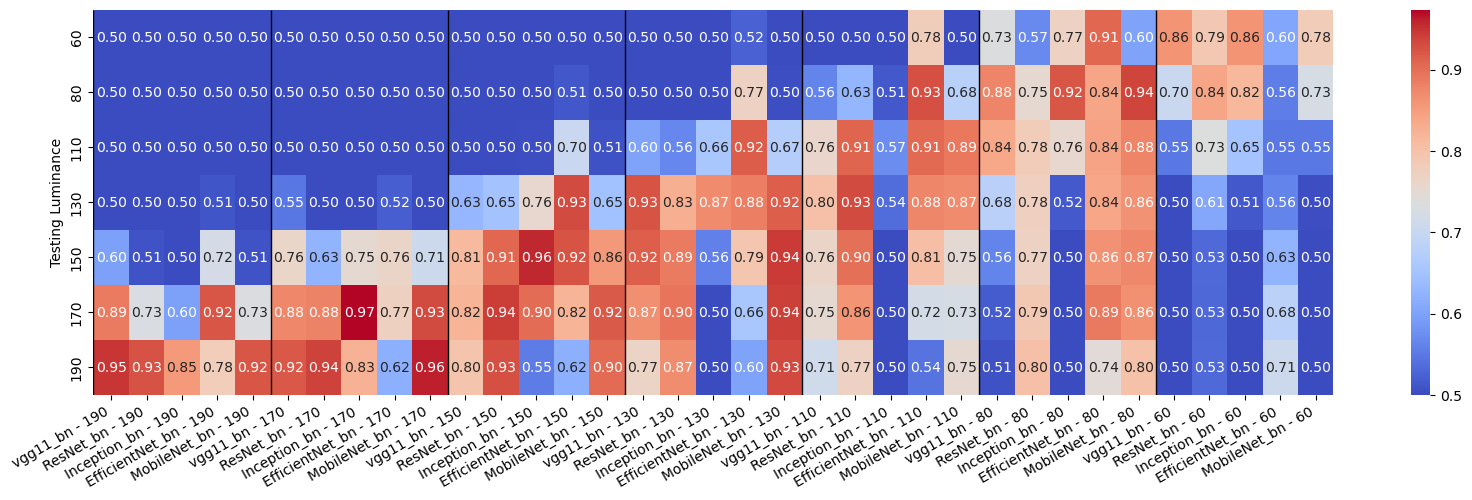

In [8]:
### Matrix heatmap grouped by Light Luminance 

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Read the data from Excel file
data = pd.read_excel(r"C:\ThesisMedia\CroppedPralines\Grouped_dataset\Thesis_Dataset_Lighting\Outputs\Testing_results.xlsx", header=0)

data.drop(['Test_Accuracy', 'Test_Recall', 'Test_Precision', 'Test_F1_Score'], axis=1, inplace=True)

# Concatenate the 'Type' column with 'X' and 'Y' columns
data['Luminance_train'] = data['Model'] + " - " + data['Train_Luminance'].astype(str)
data['Luminance_test'] = data['Test_Luminance'].astype(str).str.rstrip('p').astype(int)  # Remove 'p' from the resolution values

# Pivot the data to create a correlation matrix
correlation_data = data.pivot(index='Luminance_test', columns='Luminance_train', values='Test_mAP')

# Sort the unique Testing and Training resolution values in ascending order
sorted_resolutions_test = sorted(data['Luminance_test'].unique())

# Sort the column names (Res_train) based on the resolution values in descending order
sorted_resolutions_train = sorted(data['Luminance_train'].unique(), key=lambda x: int(x.split(" - ")[1].replace("p", "")), reverse=True)

# Reorder the rows and columns of the correlation matrix based on the sorted resolution values
correlation_data = correlation_data[sorted_resolutions_train]

# Create the correlation heatmap
plt.figure(figsize=(20, 5))
ax = sns.heatmap(correlation_data, annot=True, cmap='coolwarm', fmt='.2f')

# Add thin vertical lines every 5 columns
for col in range(0, correlation_data.shape[1], 5):
    ax.vlines(col, *ax.get_ylim(), colors='black', linewidth=1)

# Rotate x-axis labels to have a slant (e.g., 45 degrees)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

plt.title("") #mAP Matrix Heatmap
plt.xlabel("") #Model - Training resolution
plt.ylabel("Testing Luminance")
plt.show()

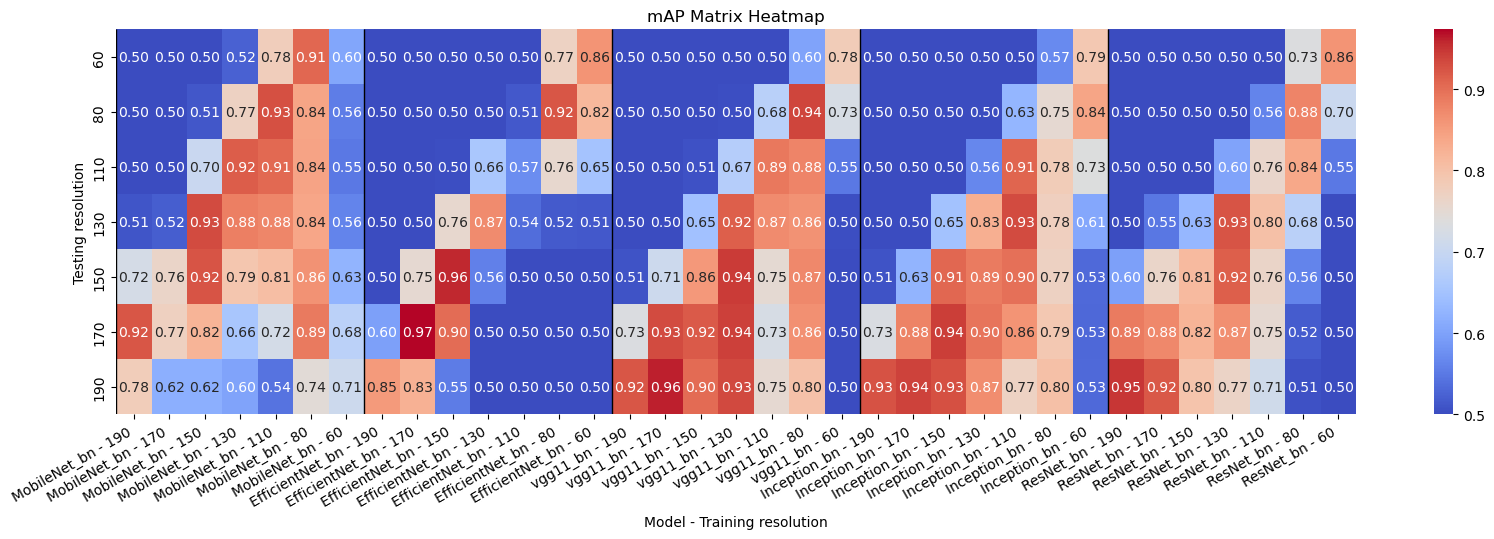

In [83]:
### Matrix heatmap grouped by model and Luminance order

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Read the data from Excel file
data = pd.read_excel(r"C:\ThesisMedia\CroppedPralines\Grouped_dataset\Thesis_Dataset_Lighting\Outputs\Testing_results.xlsx", header=0)

# data.drop(['Test_Accuracy', 'Test_Precision', 'Test_Recall', 'Test_F1_Score'], axis=1, inplace=True)

# Concatenate the 'Type' column with 'X' and 'Y' columns
data['Luminance_train'] = data['Model'] + " - " + data['Train_Luminance'].astype(str)
data['Luminance_test'] = data['Test_Luminance'].astype(str).str.rstrip('p').astype(int)  # Remove 'p' from the resolution values

# Pivot the data to create a correlation matrix
correlation_data = data.pivot(index='Luminance_test', columns='Luminance_train', values='Test_mAP')
# correlation_data = data.pivot(index='Luminance_test', columns='Luminance_train', values='Test_F1_Score')

# Sort the unique Testing and Training resolution values in ascending order
sorted_resolutions_test = sorted(data['Luminance_test'].unique(), reverse=True)

# Create a custom sort order function based on model names and resolution values
def custom_sort_order(col):
    model, resolution = col.split(" - ")
    return (model, -int(resolution.rstrip("p")))

# Sort the columns of the correlation matrix based on the custom sort order
sorted_columns = sorted(correlation_data.columns, key=custom_sort_order)
correlation_data = correlation_data[sorted_columns]

# Group x-axis labels by model
model_names = list(set(col.split(" - ")[0] for col in correlation_data.columns))
grouped_labels = [f"{model} - {res}" for model in model_names for res in sorted_resolutions_test]

# Create the correlation heatmap
plt.figure(figsize=(20, 5))
ax = sns.heatmap(correlation_data, annot=True, cmap='coolwarm', fmt='.2f')

# Add thin vertical lines every 5 columns
for col in range(0, correlation_data.shape[1], 7):
    ax.vlines(col, *ax.get_ylim(), colors='black', linewidth=1)

# Set new x-axis labels with grouped model names and resolutions
# ax.set_xticks(range(correlation_data.shape[1]))
ax.set_xticklabels(grouped_labels, rotation=30, ha='right')

plt.title("mAP Matrix Heatmap")
plt.xlabel("Model - Training resolution")
plt.ylabel("Testing resolution")
plt.show()

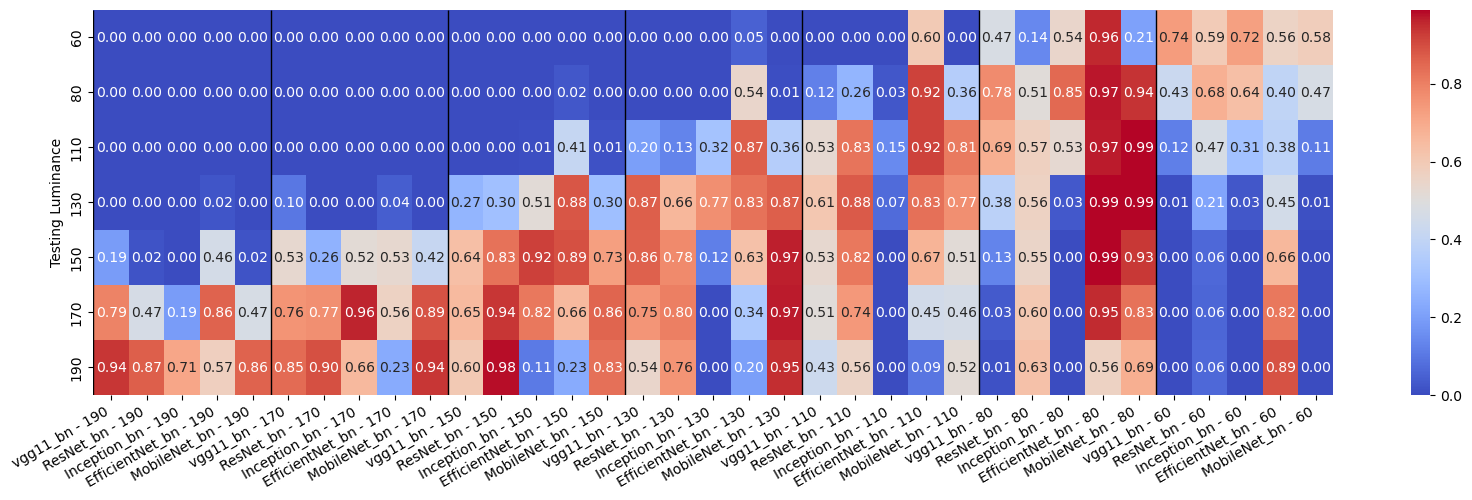

In [5]:
### Matrix heatmap grouped by Light Luminance 

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Read the data from Excel file
data = pd.read_excel(r"C:\ThesisMedia\CroppedPralines\Grouped_dataset\Thesis_Dataset_Lighting\Outputs\Testing_results.xlsx", header=0)

# data.drop(['Test_Accuracy', 'Test_Recall', 'Test_Precision', 'Test_F1_Score'], axis=1, inplace=True)

# Concatenate the 'Type' column with 'X' and 'Y' columns
data['Luminance_train'] = data['Model'] + " - " + data['Train_Luminance'].astype(str)
data['Luminance_test'] = data['Test_Luminance'].astype(str).str.rstrip('p').astype(int)  # Remove 'p' from the resolution values

# Pivot the data to create a correlation matrix
correlation_data = data.pivot(index='Luminance_test', columns='Luminance_train', values='Test_Recall')

# Sort the unique Testing and Training resolution values in ascending order
sorted_resolutions_test = sorted(data['Luminance_test'].unique())

# Sort the column names (Res_train) based on the resolution values in descending order
sorted_resolutions_train = sorted(data['Luminance_train'].unique(), key=lambda x: int(x.split(" - ")[1].replace("p", "")), reverse=True)

# Reorder the rows and columns of the correlation matrix based on the sorted resolution values
correlation_data = correlation_data[sorted_resolutions_train]

# Create the correlation heatmap
plt.figure(figsize=(20, 5))
ax = sns.heatmap(correlation_data, annot=True, cmap='coolwarm', fmt='.2f')

# Add thin vertical lines every 5 columns
for col in range(0, correlation_data.shape[1], 5):
    ax.vlines(col, *ax.get_ylim(), colors='black', linewidth=1)

# Rotate x-axis labels to have a slant (e.g., 45 degrees)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

plt.title("") #mAP Matrix Heatmap
plt.xlabel("")  #Model - Training resolution
plt.ylabel("Testing Luminance")
plt.show()

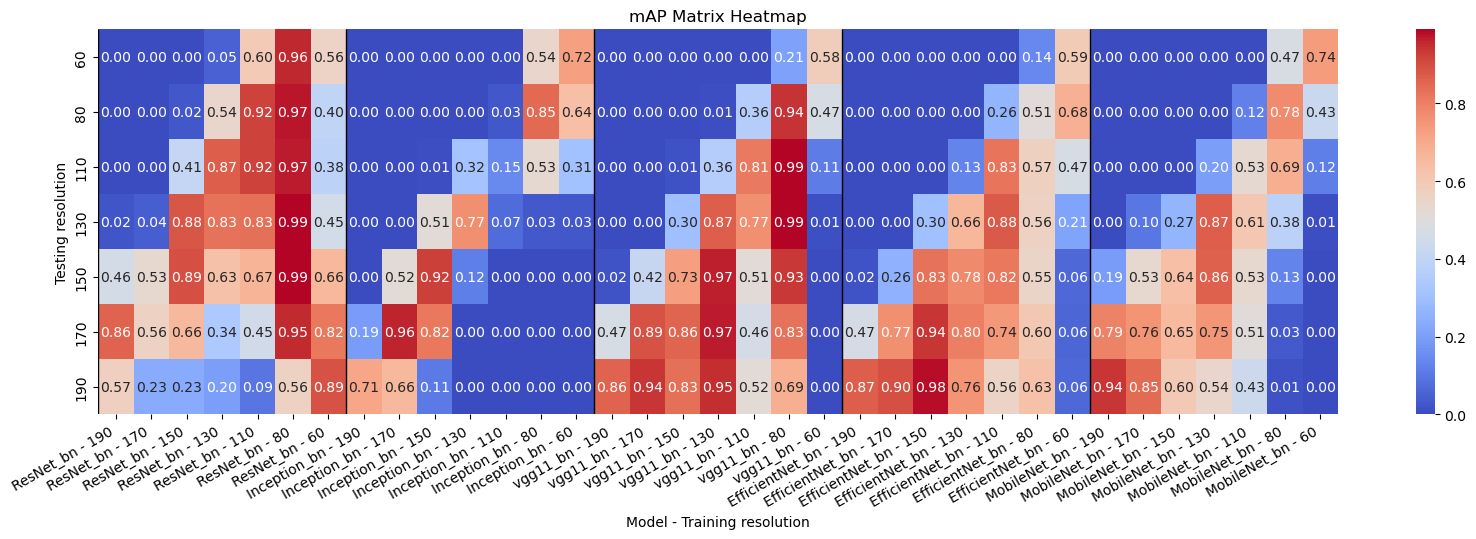

In [6]:
### Matrix heatmap grouped by model and Luminance order

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Read the data from Excel file
data = pd.read_excel(r"C:\ThesisMedia\CroppedPralines\Grouped_dataset\Thesis_Dataset_Lighting\Outputs\Testing_results.xlsx", header=0)

# data.drop(['Test_Accuracy', 'Test_Precision', 'Test_Recall', 'Test_F1_Score'], axis=1, inplace=True)

# Concatenate the 'Type' column with 'X' and 'Y' columns
data['Luminance_train'] = data['Model'] + " - " + data['Train_Luminance'].astype(str)
data['Luminance_test'] = data['Test_Luminance'].astype(str).str.rstrip('p').astype(int)  # Remove 'p' from the resolution values

# Pivot the data to create a correlation matrix
correlation_data = data.pivot(index='Luminance_test', columns='Luminance_train', values='Test_Recall')
# correlation_data = data.pivot(index='Luminance_test', columns='Luminance_train', values='Test_F1_Score')

# Sort the unique Testing and Training resolution values in ascending order
sorted_resolutions_test = sorted(data['Luminance_test'].unique(), reverse=True)

# Create a custom sort order function based on model names and resolution values
def custom_sort_order(col):
    model, light = col.split(" - ")
    return (model, -int(light))

# Sort the columns of the correlation matrix based on the custom sort order
sorted_columns = sorted(correlation_data.columns, key=custom_sort_order)
correlation_data = correlation_data[sorted_columns]

# Group x-axis labels by model
model_names = list(set(col.split(" - ")[0] for col in correlation_data.columns))
grouped_labels = [f"{model} - {res}" for model in model_names for res in sorted_resolutions_test]

# Create the correlation heatmap
plt.figure(figsize=(20, 5))
ax = sns.heatmap(correlation_data, annot=True, cmap='coolwarm', fmt='.2f')

# Add thin vertical lines every 5 columns
for col in range(0, correlation_data.shape[1], 7):
    ax.vlines(col, *ax.get_ylim(), colors='black', linewidth=1)

# Set new x-axis labels with grouped model names and resolutions
# ax.set_xticks(range(correlation_data.shape[1]))
ax.set_xticklabels(grouped_labels, rotation=30, ha='right')

plt.title("mAP Matrix Heatmap")
plt.xlabel("Model - Training resolution")
plt.ylabel("Testing resolution")
plt.show()